In [1]:
import sys
sys.path.append('code')

In [2]:
import torch
torch.manual_seed(0)
from data import create_joint_x_y

dataset_size = 1000
X, Y = create_joint_x_y(dataset_size)
X_tensor, Y_tensor = torch.Tensor(X), torch.Tensor(Y)

In [3]:
import torch
from torch import nn

class PotentialNN(nn.Module):
    def __init__(
        self,
        feature_dimension: int,
        response_dimension: int,
        hidden_dimension: int,
        number_of_hidden_layers: int,
        activation_function_name: str,
        alpha: float = 1e-2
    ):
        super().__init__()
        self.alpha = alpha
        self.activation_function_name = activation_function_name
        self.activation_function = getattr(nn, activation_function_name)()
    
        hidden_layers = []
        for _ in range(number_of_hidden_layers):
            hidden_layers.append(nn.Linear(hidden_dimension, hidden_dimension))
            hidden_layers.append(self.activation_function)

        self.potential_network = nn.Sequential(
            nn.Linear(feature_dimension + response_dimension, hidden_dimension),
            self.activation_function,
            *hidden_layers,
            nn.Linear(hidden_dimension, 1)
        )

    def forward(self, X: torch.Tensor, Y: torch.Tensor):
        input_tensor = torch.cat([X, Y], dim=-1)
        output_tensor = self.potential_network(input_tensor)
        return output_tensor + self.alpha * ( 0.5 * torch.norm(Y, dim=-1, keepdim=True)**2 )

class AmortizationNetwork(nn.Module):
    def __init__(
        self,
        feature_dimension: int,
        response_dimension: int,
        hidden_dimension: int,
        number_of_hidden_layers: int,
        activation_function_name: str
    ):
        super().__init__()
        self.activation_function_name = activation_function_name
        self.activation_function = getattr(nn, activation_function_name)()
    
        hidden_layers = []
        for _ in range(number_of_hidden_layers):
            hidden_layers.append(nn.Linear(hidden_dimension, hidden_dimension))
            hidden_layers.append(self.activation_function)

        self.amortization_network = nn.Sequential(
            nn.Linear(feature_dimension + response_dimension, hidden_dimension),
            self.activation_function,
            *hidden_layers,
            nn.Linear(hidden_dimension, response_dimension)
        )

        self.identity_projection = nn.Linear(response_dimension, response_dimension)

    def forward(self, X: torch.Tensor, Y: torch.Tensor):
        input_tensor = torch.cat([X, Y], dim=-1)
        output_tensor = self.amortization_network(input_tensor)
        input_projection = self.identity_projection(Y)
        return output_tensor + input_projection

In [4]:
def finetune_Y(X_tensor: torch.Tensor, Y_tensor: torch.Tensor, U_tensor: torch.Tensor, potential_network: nn.Module, verbose: bool = False):
            """
            Estimate Y tensor by minimizing u^T y - psi(x, y) for given x and u.
            psi(x, y) is assumed to be a potential function.

            Args:
            X_tensor (torch.Tensor): The input tensor for x, with shape [n, p].
            Y_tensor (torch.Tensor): The tensor of oversampled variables y, with shape [n, q].
            U_tensor (torch.Tensor): The tensor of oversampled variables y, with shape [n, q].

            Returns:
            torch.Tensor: A scalar tensor representing the estimated phi value.
            """
            Y = Y_tensor.clone().detach().requires_grad_(True)
            Y.requires_grad = True

            optimizer = torch.optim.LBFGS(
                [Y],
                lr=0.1,
                line_search_fn="strong_wolfe",
                max_iter=200,
                tolerance_grad=1e-10,
                tolerance_change=1e-10
            )

            def slackness_closure():
                optimizer.zero_grad()
                cost_matrix = torch.sum(U_tensor * Y, dim=-1, keepdims=True)
                phi_potential = potential_network(X_tensor, Y)
                slackness = (phi_potential - cost_matrix).sum()
                slackness.backward()
                return slackness

            optimizer.step(slackness_closure)

            if verbose:
                optimal_Y_tensor_potential = potential_network(X_tensor, Y).sum()
                approximated_U_tensor = torch.autograd.grad(optimal_Y_tensor_potential.sum(), Y)[0]
                estimation_error = (approximated_U_tensor - U_tensor)
                print(f"Maximal dual problem vector approximation error: {estimation_error.abs().mean().item()}")

            return Y.detach()

In [5]:
import torch
from tqdm.notebook import trange

num_epochs, batch_size = 5000, 256
device_and_dtype_specifications = {
        "device":torch.device("cpu"),
        "dtype":torch.float64,
}

X_tensor, Y_tensor = torch.Tensor(X), torch.Tensor(Y)
X_tensor = X_tensor.to(**device_and_dtype_specifications)
Y_tensor = Y_tensor.to(**device_and_dtype_specifications)

potential_network = PotentialNN(
        feature_dimension=1, 
        response_dimension=2, 
        hidden_dimension=16,
        number_of_hidden_layers=2,
        activation_function_name='Softplus',
        alpha=1e-2,
)
potential_network = potential_network.to(**device_and_dtype_specifications)
potential_network_optimizer = torch.optim.Adam([dict(params=potential_network.parameters())], lr=0.01)

amortization_network = AmortizationNetwork(
        feature_dimension=1, 
        response_dimension=2, 
        hidden_dimension=16,
        number_of_hidden_layers=4,
        activation_function_name='Softplus',
)
amortization_network = amortization_network.to(**device_and_dtype_specifications)
amortization_network_optimizer = torch.optim.Adam([dict(params=amortization_network.parameters())], lr=0.01)

training_information = []
progress_bar = trange(1, num_epochs+1, desc="Training")

for epoch_idx in progress_bar:
        yindexes = torch.randint(0, dataset_size, (batch_size,))
        entropy_indexes = torch.randint(0, dataset_size, (256,))

        X_batch = X_tensor[yindexes]
        Y_batch = Y_tensor[yindexes]
        U_batch = torch.randn_like(Y_batch)

        Y_amortized = amortization_network(X_batch, Y_batch)
        
        Y_finetuned = finetune_Y(
                X_tensor=X_batch,
                Y_tensor=Y_amortized,
                U_tensor=U_batch,
                potential_network=potential_network
        )

        phi_amortized = torch.sum(U_batch * Y_amortized, dim=-1, keepdims=True) - potential_network(X_batch, Y_amortized)
        amortization_network_optimizer.zero_grad()
        amortization_network_objective = -torch.mean(phi_amortized)
        amortization_network_objective.backward()
        amortization_network_optimizer.step()

        psi = potential_network(X=X_batch, Y=Y_batch)
        phi = torch.sum(U_batch * Y_finetuned, dim=-1, keepdims=True) - potential_network(X_batch, Y_finetuned)
        potential_network_optimizer.zero_grad()
        potential_network_objective = torch.mean(phi) + torch.mean(psi)
        potential_network_objective.backward(retain_graph=True)
        potential_network_optimizer.step()
 


        training_information.append({
                "potential_network_objective": potential_network_objective.detach().item(),
                "amortization_network_objective": amortization_network_objective.detach().item(),
                "epoch_index": epoch_idx,
                "epsilon": epoch_idx,
        })

        if epoch_idx % 10 == 0:
                running_mean_potential_network_objective = sum(
                        [information["potential_network_objective"] for information in training_information[-10:]]
                ) / len(training_information[-10:])

                running_mean_amortization_network_objective = sum(
                        [information["amortization_network_objective"] for information in training_information[-10:]]
                ) / len(training_information[-10:])

                progress_bar.set_description((
                        f"potential_network_objective: {running_mean_potential_network_objective:.3f}, "
                        f"amortization_network_objective: {running_mean_amortization_network_objective:.3f}"
                ))

_ = potential_network.eval()
_ = amortization_network.eval()

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

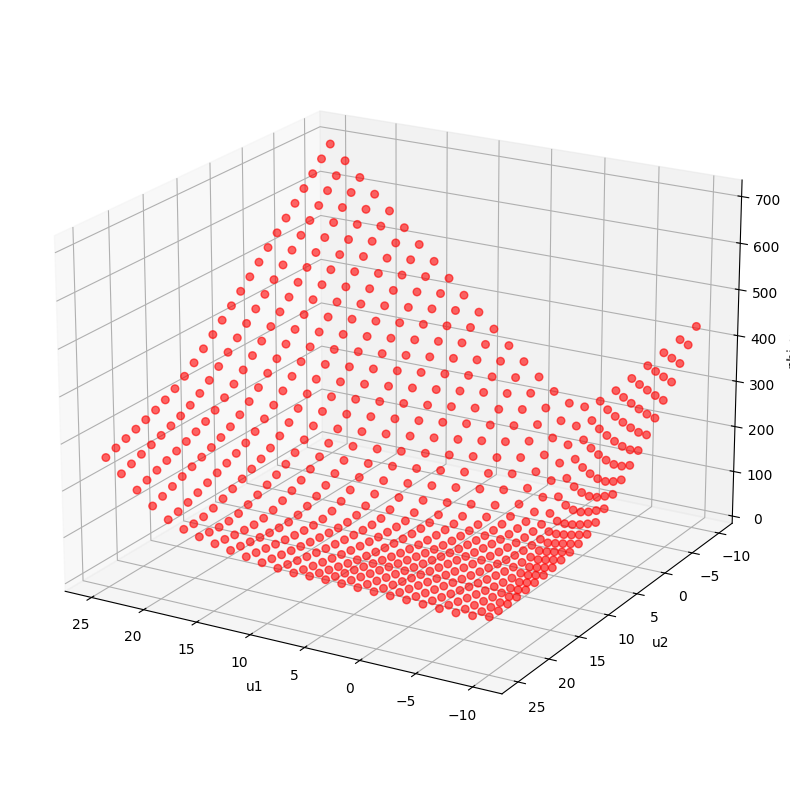

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
number_of_points_to_visualize = 1000

with torch.no_grad():
        yx = torch.linspace(-10, 25, steps=25, **device_and_dtype_specifications)
        yy = torch.linspace(-10, 25, steps=25, **device_and_dtype_specifications)
        Y_meshgrid = torch.stack(torch.meshgrid(yx, yy, indexing='xy'), dim=-1).reshape(-1, 2)
        Y_meshgrid.to(**device_and_dtype_specifications)
        X_batch = X_tensor[51:52].repeat(Y_meshgrid.shape[0], 1)
        potential_tensor = potential_network(X_batch, Y_meshgrid)

potential = potential_tensor.detach().cpu().numpy()
Y_meshgrid_numpy = Y_meshgrid.detach().cpu().numpy()
scatter = ax.scatter(Y_meshgrid_numpy[:, 0], Y_meshgrid_numpy[:, 1], potential.squeeze(), color='red', marker='o', s=30, alpha=0.6)
ax.grid(True)

ax.view_init(elev=20, azim=120)
ax.set_xlabel('u1')
ax.set_ylabel('u2')
ax.set_zlabel('phi_u')

plt.show()

In [ ]:
import typing
from scipy import stats

def pushforward_u_given_x(U: torch.Tensor, X: torch.Tensor) -> torch.Tensor:
    """
    Push forward the conditional distribution of the covariates given the response.
    """
    assert U.shape[:-1] == X.shape[:-1], (
        "The number of rows in U and X must be the same."
    )
    Y_shape = U.shape[:-1] + (2,)

    U_flat = U.reshape(-1, 2)
    X_flat = X.reshape(-1, 1)
    Y_flat = torch.concatenate(
        [
            U_flat[:, 0:1] * X_flat,
            U_flat[:, 1:2] / X_flat + (U_flat[:, 0:1] ** 2 + X_flat**3),
        ],
        dim=1,
    )
    return Y_flat.reshape(Y_shape)

def get_quantile_level_analytically(alpha: torch.Tensor, distribution: typing.Literal["gaussian", "ball"], dimension: int) -> torch.Tensor:
    """Function finds the radius, that is corresponding to alpha-quantile of the samples.

    The function is based on the fact, that the distribution of the distances is symmetric around the origin.
    So, we can find the radius, that is corresponding to alpha-quantile of the samples.

    Args:
        alpha (torch.Tensor): Level of the quantile.
        distribution (Literal["gaussian", "ball"]): Distribution of the samples.
        dimension (int): Dimension of the samples.

    Returns:
        torch.Tensor: The radius of the quantile level.
    """
    if distribution == "gaussian":
        scipy_quantile = stats.chi2.ppf(alpha.cpu().detach().numpy(), df=dimension)
        return torch.from_numpy(scipy_quantile**(1/2))
    elif distribution == "ball":
        return alpha**(1/dimension)
    else:
        raise ValueError(f"Distribution {distribution} is not supported.")

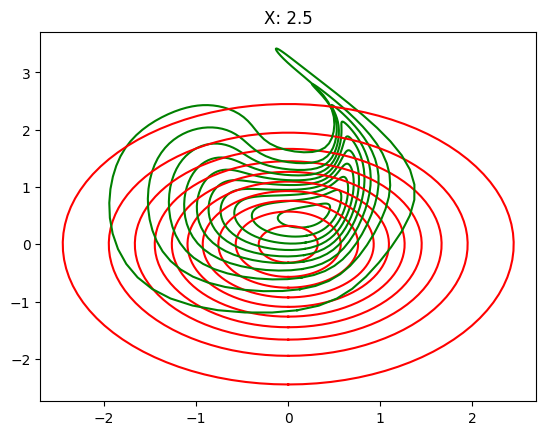

In [41]:
alphas = torch.linspace(0.05, 0.95, 10)
quantile_levels = get_quantile_level_analytically(alpha=alphas, distribution='gaussian', dimension=2).unsqueeze(1)
angles = torch.linspace(-torch.tensor(torch.pi), torch.tensor(torch.pi), 100).unsqueeze(0)
U_quantiles = torch.stack(
    [
        quantile_levels * torch.sin(angles),
        quantile_levels * torch.cos(angles),
    ], dim=-1
)
X_quantiles = torch.Tensor([[2.5]]).repeat(*U_quantiles.shape[:-1], 1)
Y_quantiles = pushforward_u_given_x(U=U_quantiles, X=X_quantiles)

Y_quantiles.requires_grad_(True)
U_approximated = torch.autograd.grad(potential_network(X_quantiles, Y_quantiles).sum(), Y_quantiles)[0]

plt.title(f"X: {X_quantiles.flatten()[0]}")
for i in range(10):
    plt.plot(U_approximated.detach().numpy()[i, :, 0], U_approximated.detach().numpy()[i, :, 1], color="green")
    plt.plot(U_quantiles.detach().numpy()[i, :, 0], U_quantiles.detach().numpy()[i, :, 1], color="red")
plt.show()